In [62]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Define a transform to convert images to tensors
transform = transforms.ToTensor()



# Load the test dataset

In [63]:
# Load the training dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transform,
                                           download=True)

In [64]:
print(train_dataset)

print(train_dataset[0][0].shape, train_dataset[0][1])

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([1, 28, 28]) 5


In [86]:
class Conv(nn.Module):
    def __init__(self):
        super(Conv, self).__init__()

        self.conv1 = nn.Conv2d(1, 3, 3) # 28x28x1 -> 26x26x3
        self.mp1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 10, 3) # 13x13x3 -> 11x11x10
        self.l1 = nn.Linear(1210, 10)

    def forward(self, x: torch.Tensor):
        if len(x.shape) == 3:
            B, H, W = x.shape
            x = x.unsqueeze(1)
        else:
            B, C, H, W = x.shape
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(self.mp1(x)))
        x = self.l1(x.view(B, -1))

        return x



In [87]:
def custom_collate_fn(batch):
    x, y_hat = zip(*batch)
    return (x, y_hat)


dataloader = DataLoader(train_dataset, batch_size=16, collate_fn=custom_collate_fn)


In [88]:
model = Conv().cuda().eval()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.)
loss_fn = torch.nn.CrossEntropyLoss()
SPLIT = 10000
EPOCHS=3

In [89]:
for item in dataloader:
    print(item[1])
    break

(5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7)


In [90]:
print(next(dataloader)[0])

TypeError: 'DataLoader' object is not an iterator

In [91]:
for i, (x, y_hat) in enumerate(dataloader):
    x = torch.stack(x).cuda()
    y_hat = torch.tensor(y_hat).cuda()
    y = model(x)

    loss = loss_fn(y, y_hat)

    if i % 1000 == 0:
        print(loss)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

tensor(2.3160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1888, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1118, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0644, device='cuda:0', grad_fn=<NllLossBackward0>)


groundtruth: 1, predicted: 1


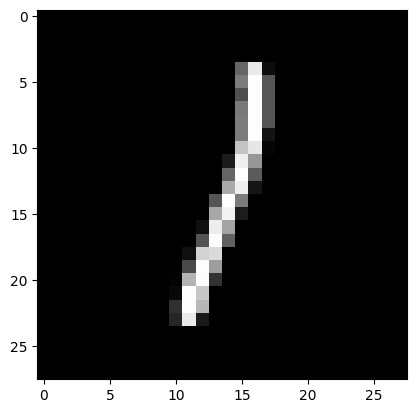

In [92]:
#(okay i get how this is kind of overfitting but) use matplotlib to plot the predicted and the actual
IDX = 2334
index = len(train_dataset) - SPLIT + IDX

x, y_hat = train_dataset[index]
predicted = torch.argmax(model(x.cuda()))
plt.imshow(x[0], cmap='grey')

print(f"groundtruth: {y_hat}, predicted: {predicted}")